<a href="https://colab.research.google.com/github/holehouse-lab/EnsPredict-colab/blob/main/example_notebooks/polymer_property_predictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to IDPEnsemble Predictor

In [1]:
#@title Install Necessary Dependencies
!pip install git+https://git@github.com/idptools/sparrow.git@polymer_predictors --quiet




  Preparing metadata (setup.py) ... done


In [2]:
#@title File Imports
import sparrow
from sparrow.predictors.batch_predict import batch_predict
from google.colab import data_table
import pandas as pd
from sparrow.sparrow_exceptions import SparrowException
import matplotlib.pyplot as plt
from google.colab import files
import io
from collections import defaultdict

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


In [3]:
#@title Target Sequence
#@markdown <h1>Enter the primary amino acid sequence:</h1>

#@markdown Notes: 

#@markdown - The following predictors implicitly assume this sequence is disordered.

#@markdown - A sequence cannot be provided at the same time as a fasta file.

# define the function that will be called when the form is submitted
def process_form():
    uploaded_data = files.upload()
    uploaded_fasta = list(uploaded_data.keys())[0]
    # Load protein objects
    try:
      protein_objs = sparrow.read_fasta(uploaded_fasta)
    except TypeError as e:
      print(f"Received TypeError: Perhaps you didn't upload a file?")
      raise e

    return protein_objs



sequence = "PKSGDEKDGGSPGKSGKRKDSPKGSRKPKGKPSGSPGKSGPKSGDEKDGGKRKDSPKGSRKD" #@param {type:"string"}
fasta_file = False #@param {type:"boolean"}


if fasta_file and len(sequence) > 0:
  raise SparrowException(f"Cannot specify both a sequence and a list of sequences from a fasta file simultaneously")

if fasta_file:
    protein_objs = process_form()
    for protein in protein_objs:
        if len(protein) > 750:
            raise SparrowException(f"Sequences longer than 750 residues are not currently supported."\
            "You entered a protein with length {len(protein)} residues")
else:
    if len(sequence) > 750:
        raise SparrowException(f"Sequences longer than 750 residues are not currently supported."\
            "You entered a protein with length {len(sequence)} residues")
    
    protein_objs = sparrow.Protein(sequence)
    

In [4]:
#@title Sequence Property Prediction

#@markdown <h1>Please select the ensemble features you'd like to predict and then press the run cell button: </h1>

#@markdown This may take some time for large fasta files. GPU batch support is currently not implemented. Power users are recommended to install sparrow to run predictions locally.

radius_of_gyration = True #@param {type:"boolean"}
end_to_end_distance = True #@param {type:"boolean"}
scaling_exponent = True #@param {type:"boolean"}
prefactor = True #@param {type:"boolean"}
asphericity = True #@param {type:"boolean"}

def return_fasta_predictions(protein_objs):
    dimensions = defaultdict(dict)

    for i, (header, protein) in enumerate(protein_objs.items(),1):
        dimensions[header].update({"length" : int(len(protein))})

        if radius_of_gyration:
            dimensions[header].update({"radius_of_gyration" : protein.predictor.radius_of_gyration()})
        
        if end_to_end_distance:
            dimensions[header].update({"end_to_end_distance" : protein.predictor.end_to_end_distance()})

        if scaling_exponent:
            dimensions[header].update({"scaling_exponent" : protein.predictor.scaling_exponent()})

        if asphericity:
            dimensions[header].update({"asphericity" : protein.predictor.asphericity()})

        if prefactor:
            dimensions[header].update({"prefactor" : protein.predictor.prefactor()})

        df = pd.DataFrame(dimensions).T
        df = df.rename_axis('fasta_header')
        
    return df

def return_individual_predictions(protein):
    dimensions = defaultdict(dict)

    dimensions[f"{protein.sequence}"].update({"length" : int(len(protein))})

    if radius_of_gyration:
        dimensions[f"{protein.sequence}"].update({"radius_of_gyration" : protein.predictor.radius_of_gyration()})
    
    if end_to_end_distance:
        dimensions[f"{protein.sequence}"].update({"end_to_end_distance" : protein.predictor.end_to_end_distance()})
    
    if scaling_exponent:
        dimensions[f"{protein.sequence}"].update({"scaling_exponent" : protein.predictor.scaling_exponent()})
    
    if asphericity:
        dimensions[f"{protein.sequence}"].update({"asphericity" : protein.predictor.asphericity()})

    if prefactor:
        dimensions[f"{protein.sequence}"].update({"prefactor" : 5.5})

    df = pd.DataFrame(dimensions).T
    
    return df

def is_iterable(obj):
    try:
        iter(obj)
        return True
    except TypeError:
        return False

if is_iterable(protein_objs):
    df = return_fasta_predictions(protein_objs)
else:
    df = return_individual_predictions(protein_objs)



display(data_table.DataTable(df, include_index=True, num_rows_per_page=5))


,asphericity,end_to_end_distance,length,prefactor,radius_of_gyration,scaling_exponent
PKSGDEKDGGSPGKSGKRKDSPKGSRKPKGKPSGSPGKSGPKSGDEKDGGKRKDSPKGSRKD,0.475029,59.990929,62.0,5.5,25.866266,0.567414


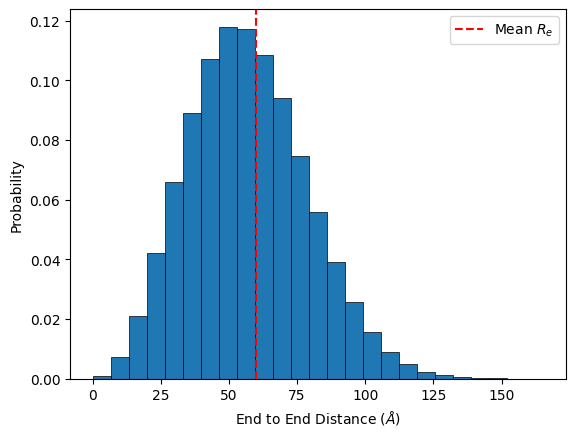

In [5]:
#@title Plot predicted end-to-end-distribution
bins = 25 #@param {type:"integer"}
if is_iterable(protein_objs):
    raise SparrowException("We don't currently support predicting end-to-end distance distributions from fasta files. Please use the single sequence method in the cell above.")

p_of_Re_R, p_of_Re_P = protein_objs.polymeric.get_predicted_nu_dep_end_to_end_distribution()
plt.hist(p_of_Re_R, weights=p_of_Re_P, linewidth=0.5, edgecolor='k',bins=bins)
plt.xlabel(r"End to End Distance ($\AA$)")
plt.ylabel("Probability")
plt.axvline(protein_objs.predictor.end_to_end_distance(), linestyle="--",color='r',label=r"Mean $R_e$")
plt.legend()
plt.show()